# Imports

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fitz as fitz
from enum import Enum
import io as io

## Classes and Enums

In [71]:
class BehaviorTitles(Enum):
	chatted_with_visitors = "Chatted with Visitors"
	chatted_with_staff = "Chatted with Staff"
	sat_on_bench = "Sat on a Bench"
	split_from_group = "Split from their Group"
	used_phone = "Used a Cell Phone"
	used_museum_guide = "Used the Museum Guide"
	used_headphones = "Used Headphones"
	read_lectern = "Read Lecterns"
	read_label = "Read Labels"
	took_photos = "Took Photos"
	
class SlipRoomTitles(Enum):
	a18_took_photos = "18A: Took Photos"
	a18_took_videos = "18A: Took Videos"
	a18_viewed_labels = "18A: Viewed Labels"
	b18_touched_casts = "18B: Touched Casts"
	b18_took_photos = "18B: Took Photos"
	b18_viewed_labels = "18B: Viewed Labels"

# Code

## Constants

In [72]:
# relative file paths
visitor_xlsx_path: str = "../../assets/excel_files/observation_tables.xlsx"

# sheet name
main_sheet_name: str = "main data"
groups_sheet_name_base: str = "object group"
indiv_sheet_name_base: str = "object indiv"

# export paths
behavior_export_path: str = "../../assets/output_files/behavior_bar_chart.png"
subbehavior_export_path: str = "../../assets/output_files/main_room_bar_chart.png"
slip_room_export_path: str = "../../assets/output_files/slip_room_bar_chart.png"

## Loading XLSX

In [73]:
visitor_xlsx: pd.ExcelFile = pd.ExcelFile(visitor_xlsx_path)
visitor_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=main_sheet_name, index_col=0)

num_visitors: int = visitor_df.shape[0]

visitor_df = visitor_df.assign(
	read_lectern=False,
	read_label=False,
	took_photos=False
)
for i in visitor_df.index.to_list():
	if visitor_df.loc[i, "lecterns_visited"] != "N":
		visitor_df.at[i, "read_lectern"] = True

	v_id: str = visitor_df.loc[i, "visitor_id"]
	groups_sheet_name: str = groups_sheet_name_base + " " + "{0:0=3d}".format(v_id)
	group_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=groups_sheet_name, index_col=0)
	for j in group_df.index.to_list():
		if group_df.loc[j, "viewed_labels"] == True:
			visitor_df.at[i, "read_label"] = True
		if group_df.loc[j, "took_photos"] == True:
			visitor_df.at[i, "took_photos"] = True
	
	indiv_sheet_name: str = indiv_sheet_name_base + " " + "{0:0=3d}".format(v_id)
	indiv_df: pd.DataFrame = pd.read_excel(visitor_xlsx, sheet_name=indiv_sheet_name, index_col=0)
	for j in indiv_df.index.to_list():
		if indiv_df.loc[j, "viewed_labels"] == True:
			visitor_df.at[i, "read_label"] = True
		if indiv_df.loc[j, "took_photos"] == True:
			visitor_df.at[i, "took_photos"] = True

visitor_df.rename(columns={
	"18a_took_photos": "a18_took_photos",
	"18a_took_videos": "a18_took_videos",
	"18a_viewed_labels": "a18_viewed_labels",
	"18b_touched_casts": "b18_touched_casts",
	"18b_took_photos": "b18_took_photos",
	"18b_viewed_labels": "b18_viewed_labels"
}, inplace=True)

visitor_df

,visitor_id,observer,tracker,time_in,time_out,total_time,group_comp,gender,room_order,lecterns_visited,...,18b_exit_time,18b_total_time,b18_touched_casts,b18_took_photos,b18_viewed_labels,tracker_map_path,additional_notes,read_lectern,read_label,took_photos
0,1,Courtney,Owen,1900-01-01 10:54:00,1900-01-01 11:16:00,22,GROUP,FEMALE,FB,WME,...,1900-01-01 11:16:00,60.0,False,False,False,../assets/tracker_images/001.pdf,crowded,True,True,True
1,2,Courtney,Owen,1900-01-01 11:17:00,1900-01-01 11:24:00,7,GROUP,MALE,F,N,...,NaT,NaN,False,False,False,../assets/tracker_images/002.pdf,NaN,False,False,True
2,3,Courtney,Owen,1900-01-01 11:25:00,1900-01-01 11:32:00,7,GROUP,FEMALE,F,N,...,NaT,NaN,False,False,False,../assets/tracker_images/003.pdf,NaN,False,False,False
3,4,Courtney,Owen,1900-01-01 11:33:00,1900-01-01 11:35:00,2,INDIVIDUAL,MALE,FB,N,...,1900-01-01 11:35:00,0.0,False,False,False,../assets/tracker_images/004.pdf,NaN,False,False,False
4,5,Courtney,Owen,1900-01-01 11:40:00,1900-01-01 11:46:00,6,GROUP,MALE,FBA,N,...,1900-01-01 11:45:00,60.0,False,True,True,../assets/tracker_images/005.pdf,NaN,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,149,Sofia,Jerry,1900-01-01 10:46:00,1900-01-01 10:57:00,11,GROUP,FEMALE,F,N,...,NaT,NaN,False,False,False,../assets/tracker_images/149.pdf,"went along back twice, revisited West Ped, cro...",False,False,False
96,150,Sofia,Jerry,1900-01-01 11:02:00,1900-01-01 11:08:00,6,GROUP,MALE,F,N,...,NaT,NaN,False,False,False,../assets/tracker_images/150.pdf,"tour blocking, PDA",False,True,False
97,151,Sofia,Jerry,1900-01-01 10:44:00,1900-01-01 10:45:00,1,INDIVIDUAL,FEMALE,F,N,...,NaT,NaN,False,False,False,../assets/tracker_images/151.pdf,NaN,False,False,False
98,152,Sofia,Jerry,1900-01-01 10:48:00,1900-01-01 11:02:00,14,GROUP,FEMALE,BFA,M,...,1900-01-01 10:50:00,120.0,False,False,True,../assets/tracker_images/152.pdf,"print guide, tour blocking",True,True,False


## Operations

### Support Functions

In [74]:
# lists of columns to analyze and snums to transform labels
BEHAVIOR_ANALYSIS_COLS: list[str] = [
	"chatted_with_visitors",
	"chatted_with_staff",
	"sat_on_bench",
	"split_from_group",
	"used_phone",
	"used_museum_guide",
	"used_headphones"
]

SUBBEHAVIOR_ANALYSIS_COLS: list[str] = [
	"read_lectern",
	"read_label",
	"took_photos",
	"used_headphones"
]

SLIP_ROOM_ANALYSIS_COLS: list[str] = [
	"b18_viewed_labels",
	"b18_touched_casts",
	"b18_took_photos",
	"a18_viewed_labels",
	"a18_took_videos",
	"a18_took_photos"
]

BEHAVIOR_ENUM_CLASSES: list[str] = [
	BehaviorTitles
]

SLIP_ROOM_ENUM_CLASSES: list[str] = [
	SlipRoomTitles
]

a_count: int = 0
b_count: int = 0
for i in range(visitor_df.shape[0]):
	if visitor_df.isnull().loc[i, "18a_total_time"] == False:
		a_count += 1
	if visitor_df.isnull().loc[i, "18b_total_time"] == False:
		b_count += 1

max_count: int = (a_count if a_count > b_count else b_count)

In [75]:
def plot_data(df: pd.DataFrame, analysis_cols: list, enum_classes: list, sort_bars: bool, title: str, x_max: int, export_path: str, show_chart: bool) -> None:
	"""
    Generates and saves a horizontal bar chart of behavior percentages.

    Analyzes specific columns to calculate the percentage of visitors 
    displaying notable behaviors, maps column names using provided Enums, 
    and saves the resulting chart as a PNG file.

    Args:
        df: The pandas DataFrame containing visitor behavioral data.
        analysis_cols: List of column names to analyze.
        enum_classes: List of Enum classes used to rename columns from
                      technical names to human-readable labels.
        export_path: File path where the resulting chart image will be saved.
        show_chart: If True, displays the chart in the current environment.
    """
	plot_df: pd.DataFrame = df.copy()
	plot_df = plot_df[analysis_cols]

	fig: plt.Figure
	ax: plt.Axes
	fig, ax = plt.subplots(figsize=(10, 6))

	master_map: dict[str, str] = {}
	for enum_cls in enum_classes:
		for member in enum_cls:
			master_map[member.name] = str(member.value)
	plot_df = plot_df.rename(columns=master_map)

	percentage_data: pd.Series = plot_df.mean() * 100
	if sort_bars:
		percentage_data = percentage_data.sort_values()

	bars: plt.BarContainer = ax.barh(
		percentage_data.index,
		percentage_data.values,
		color='lightgreen',
		edgecolor='black'
	)

	ax.set_title(title, fontsize=14)
	ax.set_xlabel('# of Visitors', fontsize=12)
	ax.set_xlim(0, x_max)
	ax.grid(axis='x', linestyle='--', alpha=0.7)

	for bar in bars:
		width: float = bar.get_width()
		ax.text(
			width + 1,
			bar.get_y() + bar.get_height() / 2,
			str(int(width)),
			va='center',
			fontsize=10
		)

	plt.tight_layout()
	if show_chart:
		plt.show()

	fig.savefig(export_path, format="png", dpi=150)
	plt.close(fig)

### Execution

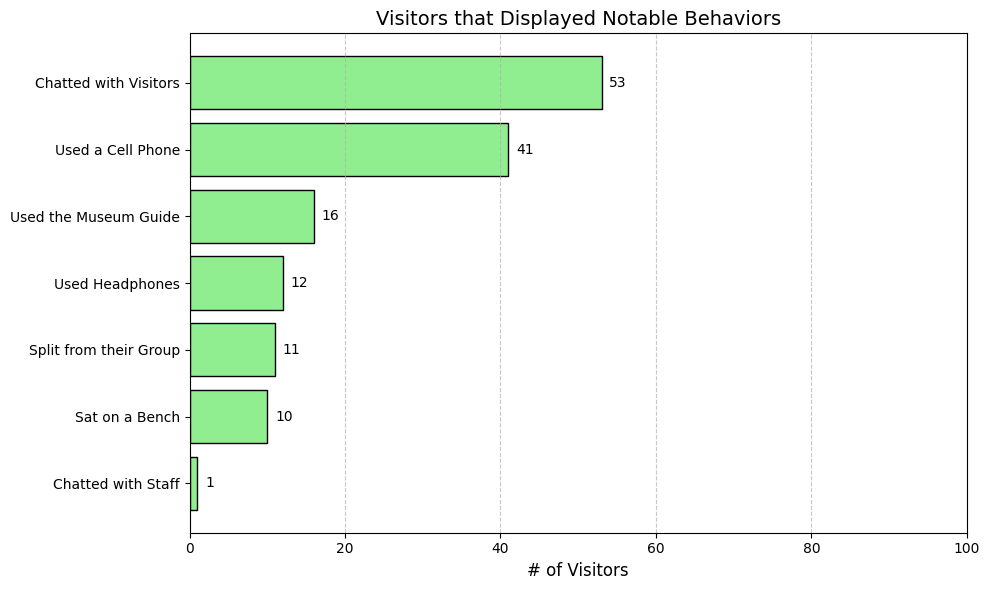

In [76]:
plot_data(visitor_df, BEHAVIOR_ANALYSIS_COLS, BEHAVIOR_ENUM_CLASSES, True, 'Visitors that Displayed Notable Behaviors', num_visitors, behavior_export_path, True)

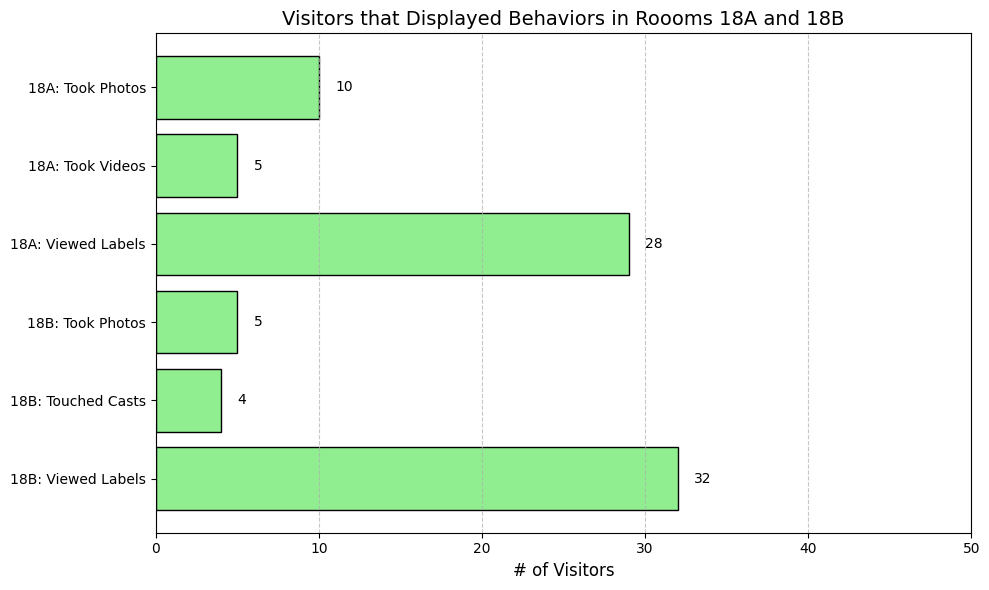

In [77]:
plot_data(visitor_df, SLIP_ROOM_ANALYSIS_COLS, SLIP_ROOM_ENUM_CLASSES, False, 'Visitors that Displayed Behaviors in Roooms 18A and 18B', max_count, slip_room_export_path, True)

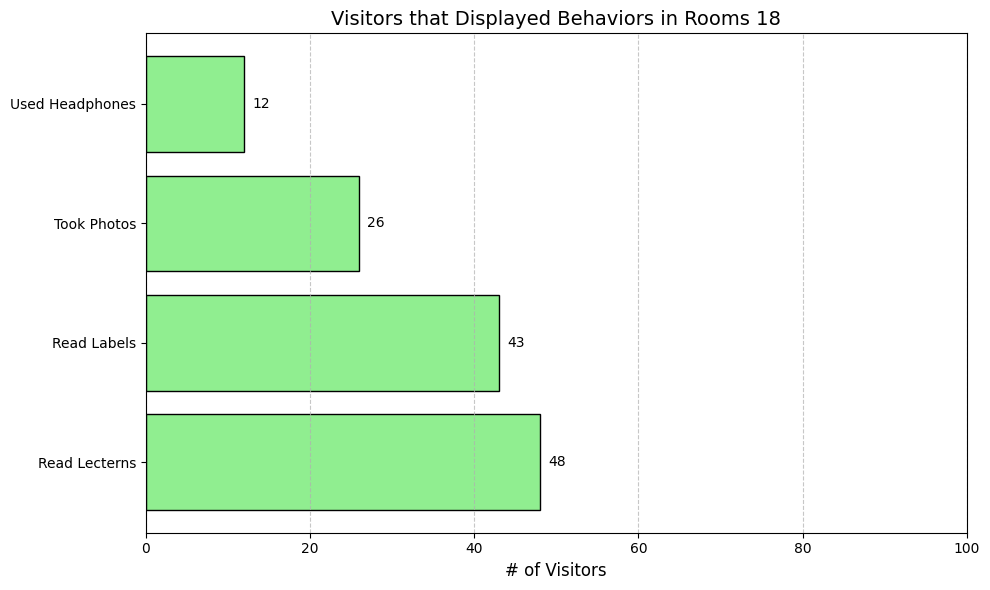

In [78]:
plot_data(visitor_df, SUBBEHAVIOR_ANALYSIS_COLS, BEHAVIOR_ENUM_CLASSES, False, 'Visitors that Displayed Behaviors in Rooms 18', num_visitors, subbehavior_export_path, True)